# Possibly the last iteration

### The plan:

- Describe the dataset
- Talk first easy NN just to see the difference in the data-cleaning part
- Data cleaning, each significant step will have its own nn try
- Different architectures
- Optimizing hyperparameters

*The LSTM ans the creation of the windows (timeseries) will be done in a separate window*

## Sensor Data

The sensors are monitoring environmental factors, we can specify the following types of sensor data:
1. Temperature (TEMP)
2. Humidity (HUM)
...

The costly sensor is assumed to measure **Black Carbon concentration (BC)**, which requires more advanced technology and calibration, thus making it more expensive.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
data = pd.read_csv("BC-Data-Set.csv")
data = data.set_index(pd.to_datetime(data['date']))
data = data[['date','N_CPC', 'PM-10', 'PM-1.0', 'NO2', 'O3', 'CO', 'NO', 'NOX', 'TEMP', 'HUM', 'BC']]
data.describe()

,N_CPC,PM-10,PM-1.0,NO2,O3,CO,NO,NOX,TEMP,HUM,BC
count,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000
mean,13.651880,15.132366,7.259924,30.032402,48.139158,0.312924,7.796788,41.608059,17.833411,70.848520,1.309454
std,8.236568,14.254218,5.479391,21.779951,26.104559,0.211781,18.525452,45.400829,6.122027,15.161241,1.122286
min,1.376000,0.600000,0.333000,2.000000,1.000000,0.100000,0.500000,1.000000,4.083000,19.383000,0.110000
25%,7.725500,8.550000,3.200000,14.000000,30.000000,0.200000,1.000000,17.000000,12.750000,60.483500,0.658500
50%,11.547000,12.883000,5.817000,23.000000,49.000000,0.200000,3.000000,28.000000,17.133000,72.083000,0.971000
75%,17.505500,18.467000,9.658500,40.000000,65.000000,0.300000,6.000000,48.000000,22.775000,83.025000,1.513000
max,73.490000,398.717000,34.383000,132.000000,142.000000,1.900000,255.000000,521.000000,34.983000,100.000000,12.767000


#now we can fill the days that are missing some hours, we will do that using the mean
test = data.groupby([data.index.date])
for group_name, group_data in test:
    if len(group_data)!=24:
        existing_hours=group_data.index.hour.unique()
        missing_hours = set(range(24)) - set(existing_hours)
        missing_rows = pd.DataFrame(columns=group_data.columns)
        for missing_hour in missing_hours:
            datetime_obj = pd.to_datetime(group_data.index.date[0]) + pd.to_timedelta(missing_hour, unit='H')
            data.loc[datetime_obj] = data.mean()

We can see that outliers are present, let's remove them.
We will scale the values too, the NN needs this to work efficiently

In [10]:
data = data.sort_index()
data = data.reset_index(drop=True)
dates = data["date"]
data = data.drop(["date"], axis=1)

In [11]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
# inspect_dataframe(data, data.columns)

In [12]:
# Normalize the data, this is a rudimentary MinMaxScaler
max_df = data.max()
min_df = data.min()

data_norm = (data - min_df)/(max_df - min_df)
data_norm = pd.DataFrame(data_norm, columns=data.columns)

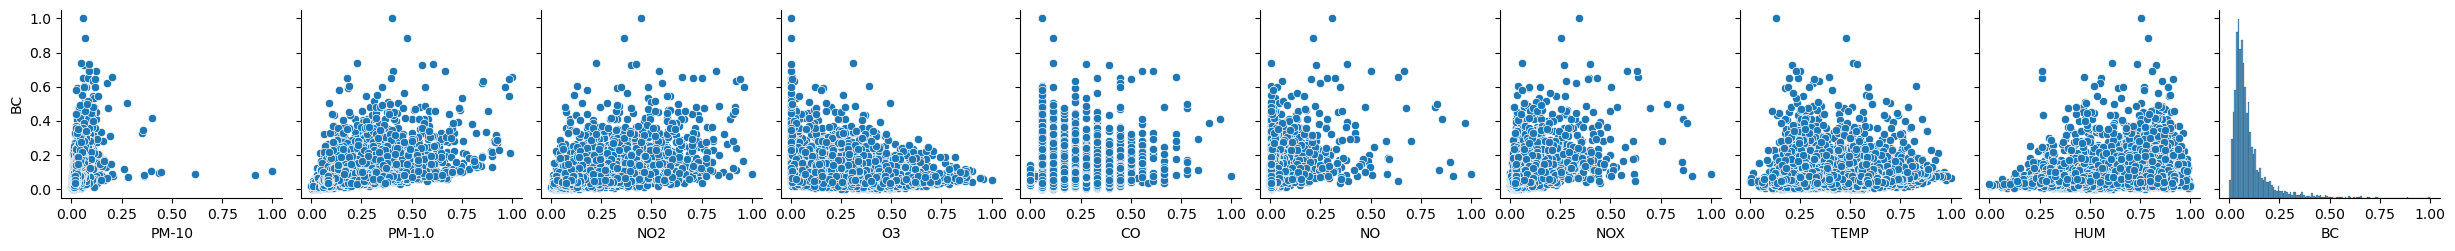

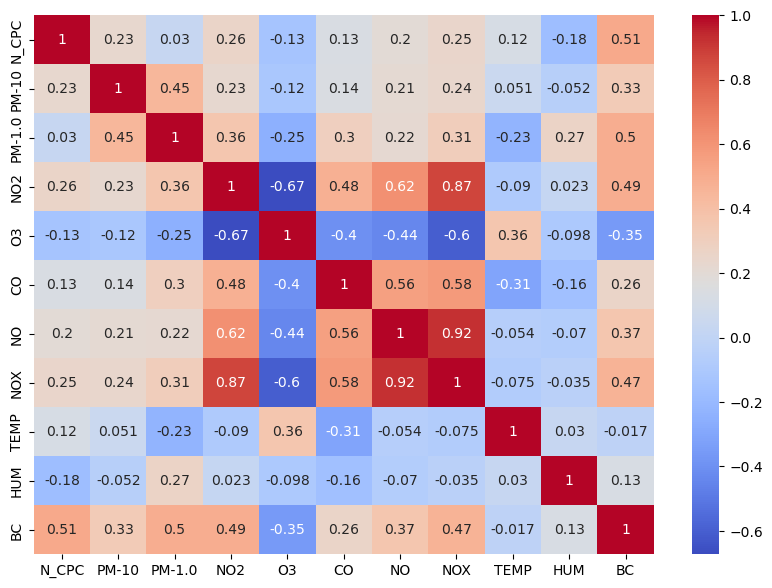

In [13]:
correlations = data_norm.corr()
# Scatter plots
sns.pairplot(data_norm, x_vars=data_norm.columns[1:], y_vars=['BC'])

# Heat map
plt.figure(figsize=(10, 7))
sns.heatmap(correlations, annot=True, cmap="coolwarm")
plt.show()

In [14]:
# inspect_dataframe(data_norm, data.columns)

#### Talk first easy NN just to see the difference in the data-cleaning part

In [15]:
import tensorflow as tf
import os
import random
import seaborn as sns
import matplotlib as mpl
import warnings
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import L1

warnings.filterwarnings("ignore")
tfk = tf.keras
tfkl = tf.keras.layers
tf.config.set_visible_devices([], 'GPU') #disables GPU
print(tf.__version__)

2.12.0


In [16]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [17]:
# just to prove that is the same as the classic MinMaxScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler

target = pd.DataFrame(data.BC)
X = data.drop(['BC'], axis=1)
print('Boston data_normset shape',X.shape)
print('Target shape', target.shape)
X.describe()

scaler_x = StandardScaler()
x_scaled = scaler_x.fit_transform(X)
x_scaled = pd.DataFrame(x_scaled, columns=X.columns)

#do the same for y

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(target) 
y_scaled = pd.DataFrame(y_scaled, columns=target.columns)


y_scaled.describe()   
x_scaled.describe()

Boston data_normset shape (4223, 10)
Target shape (4223, 1)


,N_CPC,PM-10,PM-1.0,NO2,O3,CO,NO,NOX,TEMP,HUM
count,4.223000e+03,4.223000e+03,4.223000e+03,4.223000e+03,4.223000e+03,4.223000e+03,4.223000e+03,4.223000e+03,4.223000e+03,4.223000e+03
mean,-1.211439e-16,1.346044e-16,-1.346044e-17,-1.346044e-17,1.144137e-16,-3.903526e-16,3.365109e-18,-2.692087e-17,-2.153670e-16,-8.076261e-17
std,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00,1.000118e+00
min,-1.490589e+00,-1.019634e+00,-1.264327e+00,-1.287226e+00,-1.805996e+00,-1.005520e+00,-3.939257e-01,-8.945402e-01,-2.246321e+00,-3.394947e+00
25%,-7.196058e-01,-4.618384e-01,-7.410321e-01,-7.361954e-01,-6.949478e-01,-5.332776e-01,-3.669326e-01,-5.420820e-01,-8.304461e-01,-6.837334e-01
50%,-2.555834e-01,-1.578222e-01,-2.633677e-01,-3.229224e-01,3.298058e-02,-5.332776e-01,-2.589603e-01,-2.997670e-01,-1.144220e-01,8.143306e-02
75%,4.679226e-01,2.339678e-01,4.377968e-01,4.577044e-01,6.459729e-01,-6.103483e-02,-9.700172e-02,1.408058e-01,8.072774e-01,8.032273e-01
max,7.265794e+00,2.691344e+01,4.950602e+00,4.682273e+00,3.595999e+00,7.494849e+00,1.334556e+01,1.056035e+01,2.801624e+00,1.922991e+00


In [18]:
# split in test and train

X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size = 0.15, shuffle=True)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# test_size = 24*19

# X_train = x_scaled.iloc[:-test_size]
# y_train = y_scaled.iloc[:-test_size]
# X_test = x_scaled.iloc[-test_size:]
# y_test = y_scaled.iloc[-test_size:]


# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

(3589, 10) (3589, 1)
(634, 10) (634, 1)


threshold = 3# theshold a little high to retain some outliers
z_scores = np.abs((X_train - X_train.mean()) / X_train.std())
outliers = (z_scores > threshold).any(axis=1)
for column in X_train.columns:
    column_median = X_train[column].median()
    X_train.loc[outliers, column] = column_median

z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
outliers = (z_scores > threshold).any(axis=1)
for column in y_train.columns:
    column_median = y_train[column].median()
    y_train.loc[outliers, column] = column_median

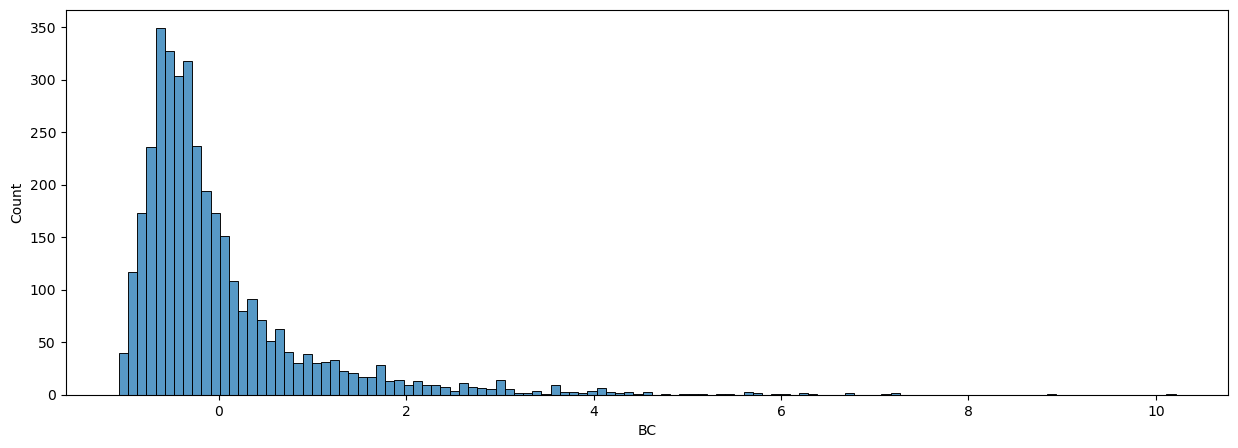

In [19]:
# Inspect the target
plt.figure(figsize=(15,5))
sns.histplot(data=y_train, x='BC')
plt.show()

In [20]:
input_shape = X_train.shape[1:]
input_shape

(10,)

In [21]:
from tensorflow.keras import regularizers

In [114]:
def build_ffnn(input_shape):

    # Build the neural network layer by layer
    input_layer = tf.keras.layers.Input(shape=input_shape, name='Input')
    layer = tfkl.Normalization()(input_layer)
    layer = tf.keras.layers.Dense(units=64, activation='elu')(layer)
    layer = tf.keras.layers.Dense(units=40, activation='elu')(layer)
    output_layer = tf.keras.layers.Dense(units=1, activation='linear', name='Output')(layer)


    # Connect input and output through the Model class
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='FFNN')

    # Compile the model
    loss = tf.keras.losses.MeanSquaredError()
    optimizer= tf.keras.optimizers.Adam(0.001)
    model.compile(loss=loss, optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])

    # Return the model
    return model

In [115]:
batch_size = 64
epochs = 500

In [116]:
ffnn = build_ffnn(input_shape)

history = ffnn.fit(
    x = X_train,
    y = y_train, 
    batch_size = batch_size,
    validation_split=0.2,
    verbose=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
        # tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
                            ],
    epochs = epochs
).history

In [117]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred=ffnn.predict(X_test)
print("RMSE",mean_squared_error(scaler_y.inverse_transform(y_test),scaler_y.inverse_transform(y_pred), squared=False))
print("R2",r2_score(scaler_y.inverse_transform(y_test),scaler_y.inverse_transform(y_pred)))

20/20 [==============================] - 0s 411us/step
RMSE 0.5178401820077251
R2 0.7652325495368967


In [110]:
import tensorflow.keras.backend as K

def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def build_ffnn(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    layer = tfkl.Normalization()(input_layer)
    layer = tfkl.Dense(units=1000, activation='relu', kernel_regularizer=regularizers.L2(l2=1e-5))(layer)
    layer = tfkl.Dense(units=200, activation='relu', kernel_regularizer=regularizers.L2(l2=1e-5))(layer)
    layer = tfkl.Dense(units=50, activation='relu', kernel_regularizer=regularizers.L2(l2=1e-5))(layer)
    # layer = tfkl.Dropout(rate=0.5)(layer)
    # layer = tfkl.Dense(units=16, activation='relu')(layer)
    output_layer = tfkl.Dense(units=1, activation='linear', name='Output')(layer)


    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='FFNN')

    # Compile the model
    loss = tfk.losses.MeanSquaredError()
    optimizer= tfk.optimizers.legacy.Adam(0.001)
    model.compile(loss=loss, optimizer=optimizer, metrics=[r2_score])

    # Return the model
    return model

In [111]:
batch_size = 32 #16 the results are not good, 32 seems optimal
epochs = 500

In [112]:
ffnn = build_ffnn(input_shape)

history = ffnn.fit(
    x = X_train,
    y = y_train, 
    batch_size = batch_size,
    validation_split=0.3,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_r2_score', mode='max', patience=15, factor=0.2, min_lr=1e-5)
                            ],
    epochs = epochs
).history

Epoch 1/500
79/79 [==============================] - 0s 2ms/step - loss: 0.3960 - r2_score: 0.5128 - val_loss: 0.4090 - val_r2_score: 0.5077 - lr: 0.0010
Epoch 2/500
79/79 [==============================] - 0s 2ms/step - loss: 0.3160 - r2_score: 0.6233 - val_loss: 0.2929 - val_r2_score: 0.6678 - lr: 0.0010
Epoch 3/500
79/79 [==============================] - 0s 2ms/step - loss: 0.2714 - r2_score: 0.6454 - val_loss: 0.2749 - val_r2_score: 0.6882 - lr: 0.0010
Epoch 4/500
79/79 [==============================] - 0s 2ms/step - loss: 0.2507 - r2_score: 0.7008 - val_loss: 0.3134 - val_r2_score: 0.6967 - lr: 0.0010
Epoch 5/500
79/79 [==============================] - 0s 2ms/step - loss: 0.2535 - r2_score: 0.6877 - val_loss: 0.2715 - val_r2_score: 0.7076 - lr: 0.0010
Epoch 6/500
79/79 [==============================] - 0s 2ms/step - loss: 0.2242 - r2_score: 0.7103 - val_loss: 0.3141 - val_r2_score: 0.6986 - lr: 0.0010
Epoch 7/500
79/79 [==============================] - 0s 2ms/step - loss: 0.2

In [113]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred=ffnn.predict(X_test)
print("RMSE",mean_squared_error(scaler_y.inverse_transform(y_test),scaler_y.inverse_transform(y_pred), squared=False))
print("R2",r2_score(scaler_y.inverse_transform(y_test),scaler_y.inverse_transform(y_pred)))

20/20 [==============================] - 0s 519us/step
RMSE 0.5223653667479358
R2 0.7611115565984665


In [71]:
def plot_residuals(model, X_, y_):
    X=X_.copy()
    y=y_.copy()
    X['sort'] = y
    X = X.sort_values(by=['sort'])
    y = np.expand_dims(X['sort'], 1)
    X.drop(['sort'], axis=1, inplace=True)

    y_pred = model.predict(X)
    SSE = np.square(scaler_y.inverse_transform(y_pred) - scaler_y.inverse_transform(y))
    MSE = np.mean(SSE)

    print('Mean Squared Error (MSE):', MSE)
    # mpl.rcParams.update(mpl.rcParamsDefault)
    # sns.set(font_scale=1.1, style=None, palette='Set1')
    plt.figure(figsize=(20,5))
    plt.scatter(np.arange(len(y)), y, label='True')
    plt.scatter(np.arange(len(y_pred)), y_pred, label='Prediction')
    
    for i in range(len(y_)):
        if(y[i]>=y_pred[i]):
            plt.vlines(i,y_pred[i],y[i],alpha=.5)
        else:
            plt.vlines(i,y[i],y_pred[i],alpha=.5)
            
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

20/20 [==============================] - 0s 584us/step
Mean Squared Error (MSE): 0.2825983904400349


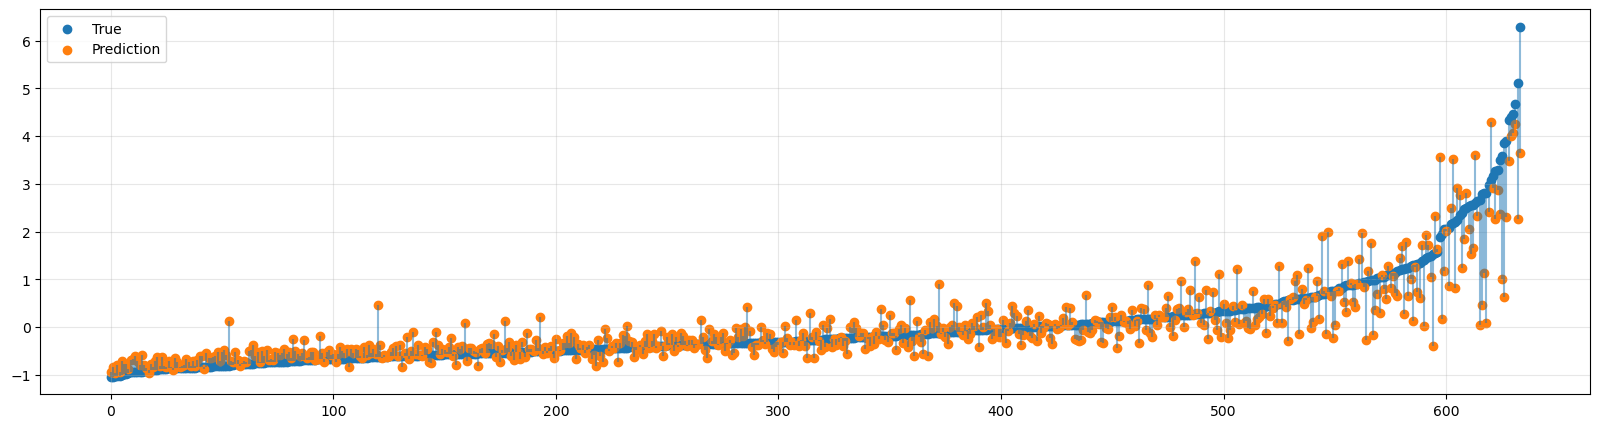

In [25]:
plot_residuals(ffnn, X_test, y_test)

113/113 [==============================] - 0s 618us/step
Mean Squared Error (MSE): 0.1471148350679157


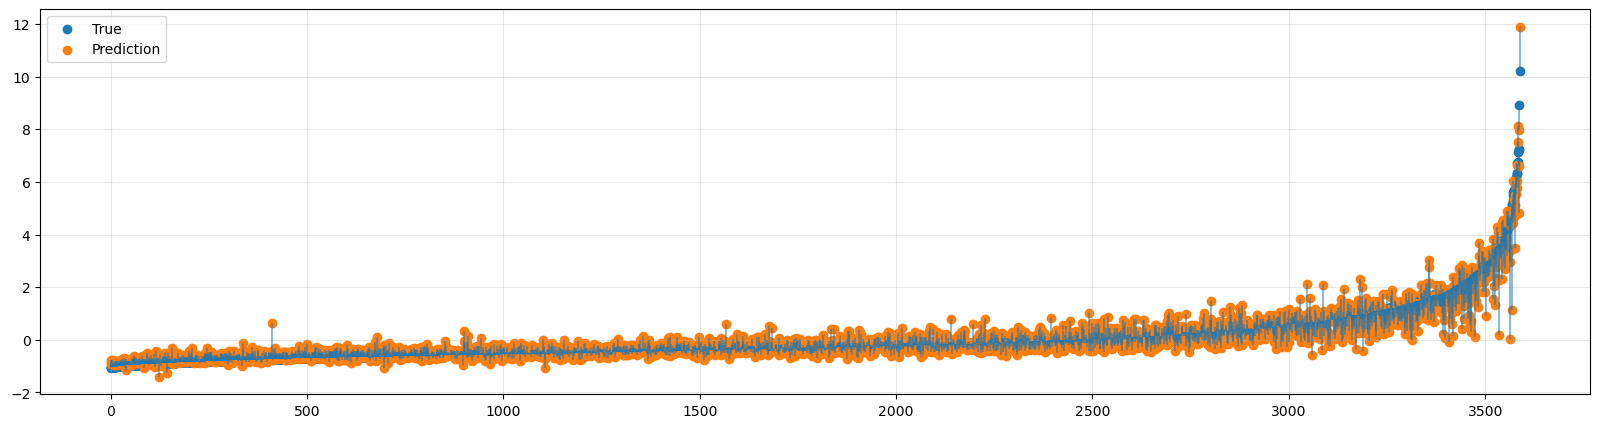

In [26]:
plot_residuals(ffnn, X_train, y_train)

Features Tuner

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler, StandardScaler
tf.config.set_visible_devices([], 'GPU') #disables GPU

data = pd.read_csv("BC-Data-Set.csv")
data = data.set_index(pd.to_datetime(data['date']))
data = data.sort_index()
data = data.reset_index(drop=True)
dates = data["date"]
data = data.drop(["date"], axis=1)

In [11]:
target = pd.DataFrame(data.BC)
data = data.drop(['BC'], axis=1)

scaler_x = MinMaxScaler()
x_scaled = scaler_x.fit_transform(data)
x_scaled = pd.DataFrame(x_scaled, columns=data.columns)

#do the same for y

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target) 
y_scaled = pd.DataFrame(y_scaled, columns=target.columns)


print(y_scaled.describe())   
x_scaled.describe()

                BC
count  4223.000000
mean      0.094766
std       0.088669
min       0.000000
25%       0.043336
50%       0.068026
75%       0.110848
max       1.000000


,N_CPC,PM-10,PM-2.5,PM-1.0,NO2,O3,SO2,CO,NO,NOX,TEMP,HUM
count,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000
mean,0.170229,0.036503,0.115317,0.203434,0.215634,0.334320,0.069477,0.118291,0.028671,0.078092,0.444997,0.638395
std,0.114216,0.035804,0.079777,0.160922,0.167538,0.185139,0.063946,0.117656,0.072792,0.087309,0.198124,0.188065
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.088048,0.019969,0.059607,0.084200,0.092308,0.205674,0.040000,0.055556,0.001965,0.030769,0.280485,0.509824
50%,0.141041,0.030853,0.097376,0.161057,0.161538,0.340426,0.040000,0.055556,0.009823,0.051923,0.422330,0.653708
75%,0.223667,0.044879,0.149346,0.273877,0.292308,0.453901,0.120000,0.111111,0.021611,0.090385,0.604919,0.789436
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=42)

In [13]:
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


In [14]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
def evaluate_feature_combinations(X_train, X_test, y_train, y_test):
    best_r2 = -np.inf
    best_rmse = np.inf
    best_combination = None

    for i in range(11, X_train.shape[1] + 1):
        for feature_combination in combinations(range(X_train.shape[1]), i):
            X_train_subset = X_train.iloc[:, list(feature_combination)]
            X_test_subset = pd.DataFrame(X_test).iloc[:, list(feature_combination)]
            
            model = create_model(X_train_subset.shape[1])
            model.fit(X_train_subset, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)])

            y_pred = model.predict(X_test_subset)
            r2 = r2_score(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            if r2 > best_r2 and rmse < best_rmse:
                best_r2 = r2
                best_rmse = rmse
                best_combination = feature_combination

    return best_r2, best_rmse, best_combination


In [17]:
best_r2, best_rmse, best_combination = evaluate_feature_combinations(X_train, X_test, y_train, y_test)
print(f"Best R2: {best_r2}")
print(f"Best RMSE: {best_rmse}")
print(f"Best feature combination: {best_combination}")


27/27 [==============================] - 0s 428us/step
Best R2: 0.7393855992061773
Best RMSE: 0.04192097398708
Best feature combination: (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11)


In [ ]:
#CO	NO	NOX	TEMP